In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import sqlite3
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

In [5]:
stack = 'MD594'
db_dir = os.environ['ROOT_DIR'] + 'CSHL_databases/'
if not os.path.exists(db_dir):
    os.mkdir(db_dir)
db_dir += stack + '/'
if not os.path.exists(db_dir):
    os.mkdir(db_dir)
img_dir = os.environ['ROOT_DIR'] + 'CSHL_cells_images/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
img_dir += stack + '/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

In [2]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [128]:
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

ALREADY DOWNLOADED FILE


In [129]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
section = 99
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)

ALREADY DOWNLOADED FILE


In [184]:
conn = sqlite3.connect(db_dir+str(section)+'.db')
cur = conn.cursor()

In [131]:
cur.execute('''CREATE TABLE Features 
               (section int, x int, y int,
                DMVec1 real, DMVec2 real, DMVec3 real, DMVec4 real, DMVec5 real,
                DMVec6 real, DMVec7 real, DMVec8 real, DMVec9 real, DMVec10 real,
                area int, height int, horiz_std real, mean real, padded_size int,
                rotation real, rotation_confidence real, std real, vert_std real, width int)''')

In [168]:
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

In [133]:
m, n

(11104, 17216)

In [134]:
xs, ys = np.meshgrid(np.arange(0, n, 1000), np.arange(0, m, 1000), indexing='xy')
locations = np.c_[xs.flat, ys.flat]

In [135]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()
extractor = patch_extractor(params)
images_all = pd.DataFrame()

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [136]:
left = locations[87][0]
right = int(min(left+1000, n))
up = locations[87][1]
down = int(min(up+1000,m))

In [145]:
%%time
tile = img[up:down, left:right]
if params['preprocessing']['polarity']==-1:
    tile = 255-tile
Stats = extractor.segment_cells(tile)
cells = extractor.extract_blobs(Stats,tile)
cells = pd.DataFrame(cells)
#cells = cells[cells['padded_patch'].notnull()]

CPU times: user 36.8 ms, sys: 2.74 ms, total: 39.5 ms
Wall time: 36.9 ms


In [180]:
tile = img[up:down, left:right]
type(tile)
tile.max()

255

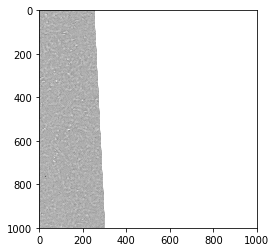

In [181]:
tile=tile/tile.max()*255
tile=tile.astype(np.uint8)
imshow(tile,cmap='gray')

In [182]:
cells

""


In [116]:
cells['section'] = section
cells['x'] = cells['left'] + left + cells['width']/2
cells['y'] = cells['top'] + up +cells['height']/2
cells = cells.astype({'x': int, 'y': int})

In [108]:
images = cells[['section', 'x', 'y', 'padded_patch']]
images_all =pd.concat([images_all, images], ignore_index=True)
# img_out_file = img_dir + str(section)
# images.to_pickle(img_out_file)

In [117]:
cells = cells.drop(['padded_patch','left','top'],1)
cells = np.asarray(cells)
for k in range(len(cells)):
    cells[k][0] = cells[k][0][:10]
features = np.concatenate((cells[:,-3:], np.array(list(cells[:,0])),cells[:,1:-3]),axis=1)

In [121]:
features[0:2]

array([[168, 1593, 6, 4.109909885617509, -1.2870128070762894,
        -1.2004753207204446, -0.049244788371834665, -1.0571741505949546,
        1.2042090636916432, -0.36240426772481044, 0.10882032869778066,
        0.8005821558939126, -0.2696772283188138, 110, 10,
        2.136481069191512, 5.9640831758034025, 51, -83.3477111226304,
        1364.9723659289205, 13.132616978207176, 3.6762074158920113, 16],
       [168, 1020, 15, -1.583713977883637, 1.4405948019673338,
        -1.3954528174412069, -0.32175728155479827, 1.030303528007469,
        0.7542561751778836, -0.18481647782551552, 0.7866518465343114,
        -0.7555683035607482, 0.22366372819162036, 320, 24,
        4.688070508986538, 9.798269334775554, 51, 83.93008264822427,
        1287.652059588039, 23.149778665851613, 5.487856302159731, 25]],
      dtype=object)

In [118]:
cur.executemany('INSERT INTO Features VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', features)

In [185]:
cur.execute('SELECT * FROM features')
cur.fetchone()

(99,
 582,
 28,
 2.1569347383013837,
 -0.01914680328072571,
 -1.6122909279649926,
 -0.23599463104881072,
 -0.21962428264338862,
 0.5443551698033889,
 0.5093988511999487,
 -0.6378635931132551,
 -0.06127104029023334,
 -0.31247472113482994,
 16,
 6,
 0.7490711464169707,
 1.4938271604938271,
 15,
 -9.379061332401117,
 105.69843182163682,
 3.8622051424955535,
 1.1953065917778858,
 4)

In [120]:
cur.fetchone()

(168,
 1020,
 15,
 -1.583713977883637,
 1.4405948019673338,
 -1.3954528174412069,
 -0.32175728155479827,
 1.030303528007469,
 0.7542561751778836,
 -0.18481647782551552,
 0.7866518465343114,
 -0.7555683035607482,
 0.22366372819162036,
 320,
 24,
 4.688070508986538,
 9.798269334775554,
 51,
 83.93008264822427,
 1287.652059588039,
 23.149778665851613,
 5.487856302159731,
 25)

In [183]:
script = os.environ['REPO_DIR']
! python $script/Sqlite.py 'MD594' 99 'shape_params.yaml'

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
0 216
1 216
2 216
3 216
4 216
5 216
6 216
7 216
8 216
9 216
10 216
11 216
12 216
13 216
14 216
15 216
16 216
17 216
18 216
19 216
20 216
21 216
22 216
23 216
24 216
25 216
26 216
27 216
28 216
29 216
30 216
31 216
32 216
33 216
34 216
35 216
36 216
37 216
38 216
39 216
40 216
41 216
42 216
43 216
44 216
45 216
46 216
47 216
48 216
49 216
50 216
51 216
52 216
53 216
54 216
55 216
56 216
57 216
58 216
59 216
60 

In [187]:
a = np.array([0,1,2,3,4,5,6,7,8])
a[0::2]

array([0, 2, 4, 6, 8])

In [4]:
setup_download_from_s3('CSHL_databases/MD594/')

download: s3://mousebrainatlas-data/CSHL_databases/MD594/102.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/102.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/103.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/103.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/105.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/105.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/106.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/106.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/104.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/104.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/107.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/107.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/110.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/110.db
download: s3://mousebrainatlas-data/CSHL_databas

download: s3://mousebrainatlas-data/CSHL_databases/MD594/225.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/225.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/223.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/223.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/228.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/228.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/224.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/224.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/230.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/230.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/229.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/229.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/233.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/233.db
download: s3://mousebrainatlas-data/CSHL_databas

download: s3://mousebrainatlas-data/CSHL_databases/MD594/328.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/328.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/347.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/347.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/349.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/349.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/350.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/350.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/348.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/348.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/354.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/354.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/351.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/351.db
download: s3://mousebrainatlas-data/CSHL_databas

In [6]:
section = 200
conn = sqlite3.connect(db_dir+str(section)+'.db')
cur = conn.cursor()

In [31]:
%%time
raws = cur.execute('SELECT * FROM features WHERE x >= 1000 AND x <= 5000 AND y >= 1000 AND y<= 5000')
print(len(list(raws)))

15025
CPU times: user 96.6 ms, sys: 14.5 ms, total: 111 ms
Wall time: 115 ms


In [30]:
133/18718

0.007105459985041137

In [24]:
len(a)

876

In [9]:
n = 0
for raw in raws:
    print(raw)

(200, 3084, 3014, 2.8063508317196137, 0.41663084002137835, -0.6087435827140384, -1.005744267317436, -0.035277336306381454, 0.38430734506368236, -0.9194480777374305, 0.1343451179478285, 0.8817521485524208, 0.44530176867276117, 11, 5, 0.7649733699239392, 0.21487603305785125, 15, 31.181339789411567, 51.68344327324016, 0.8352424458262901, 1.042365442947645, 4)
(200, 3084, 3020, 2.242259712337181, 0.24233601946283329, -1.7525435972118415, -0.30743426179201044, -0.6578714578770994, 0.7442296623715077, -0.23504383743867563, 0.3777217744777256, 1.182018537070366, -0.21215585059813824, 13, 4, 0.6021847415896182, 0.5867768595041323, 15, -89.55726869737848, 258.8235294115173, 2.126843085935535, 1.1115166003914925, 6)
(200, 3057, 3038, 1.6757686229341842, 0.4679210433155536, -2.2619015264772737, 1.0768099877578414, 0.3709032258652196, 0.5657124818271475, -0.2788961368576143, 0.26751960463925567, -0.993407575341686, -0.8217357053167456, 15, 5, 0.7925142029197664, 0.9504132231404959, 15, -49.0528789

In [3]:
import bloscpack

In [9]:
stack = 'MD635'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

download: s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_sorted_filenames.txt to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD635/MD635_sorted_filenames.txt


In [10]:
section = 200
fn = section_to_filename[200] + '_prep2_down8_detector1/'
fp = 'CSHL_scoremaps/down8/' + stack +'/'+ stack+ '_prep2_down8_detector1/' +fn
print(fp)
setup_download_from_s3(fp)

CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1

download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CS

In [11]:
from glob import glob
maps = [dir for dir in glob(os.environ['ROOT_DIR']+fp+'*')]

In [13]:
for item in maps:
    scoremap = bloscpack.unpack_ndarray_file(item)
    img = scoremap * 255
    img = img.astype(np.uint8)
    point1 = item.rfind('_')
    point2 = item[:point1].rfind('_')
    struc = item[point2+1:point1]
    print(struc)
    filename = 'CSHL_scoremaps/down8/' + stack +'/imgs/'+str(section)+'_'+struc+ '.jpg'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, img)

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


VCA
VLL


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Amb
RtTg


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


7N
Sp5I


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


DC
6N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


LRt
IC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Sp5O
SNC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Sp5C
12N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


RMC
10N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


LC
PBG


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


SNR
SC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


4N
3N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Pn
VCP


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


5N
AP
Tz


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


In [64]:
item = maps[0]
point1 = item.rfind('_')
point2 = item[:point1].rfind('_')
item[point2+1:point1]

'IC'

In [46]:
scoremap = bloscpack.unpack_ndarray_file(maps[0])

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  """Entry point for launching an IPython kernel.


In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [58]:
img = scoremap * 255
img = img.astype(np.uint8)

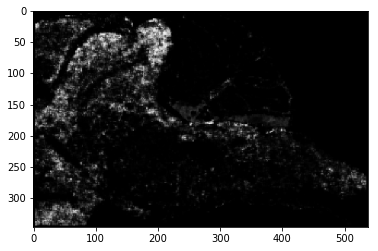

In [59]:
imshow(img, cmap='gray')

In [80]:
10/0.46

21.73913043478261